In [40]:
import numpy as np
from loadmodules import *
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

%matplotlib inline
rcParams['figure.facecolor'] = 'white'

In [2]:
parent_dir = './level4/'
simulation_list = [directory for directory in os.listdir(parent_dir) if 'Au06_cfea_fid' in directory]
print(simulation_list)

compare_lifetime = []
compare_lossratio = []
compare_initialrh = []
compare_finalrh = []
compare_initialmass = []
compare_finalmass = []
compare_mlshock = []
compare_mlrelax = []

['Au06_cfea_fiducial']


In [296]:
sim_id = 0
snap_id = 127
print('Loading simulation ', simulation_list[sim_id], ' snapshot ', snap_id)
sf = load_subfind(snap_id, dir=parent_dir+simulation_list[sim_id]+'/output/', hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
s = gadget_readsnap(snap_id, snappath=parent_dir+simulation_list[sim_id]+'/output/', subfind=sf, hdf5=True, applytransformationfacs=True, loadonlyhalo=0, loadonlytype=[4])
s.calc_sf_indizes( sf )
s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

Loading simulation  Au06_cfea_fiducial  snapshot  127
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.


array([[-0.05904483,  0.35439216,  0.93323089],
       [ 0.49324374, -0.80241338,  0.3359217 ],
       [ 0.86788497,  0.48014474, -0.12742336]])

In [297]:
solar_mass_g = 1.989e33
Gcosmo = 43.
G_cgs = 6.6738e-8 # cm^3 g^-1 s^-2
k = 1.3807e-16 # boltzmann constant in erg/K (g*cm^2/s^2/K)
parsec = 3.08567758e18 # cm
gyr = 3.15576e16 # seconds

s.parameters['UnitTime_in_s'] = s.parameters['UnitLength_in_cm']/s.parameters['UnitVelocity_in_cm_per_s']

In [298]:
galrad = sf.data['frc2'][0]
starparts = (s.data['age']>0.) * (s.r()<galrad) * (s.data['subhalo']==0)

mask_cluster_initial = (s.data['incl'][starparts]>0)
mask_cluster_final = (s.data['nclt'][starparts]>0)
truncation_mass = s.data['mtrc'][starparts][mask_cluster_initial] * s.UnitMass_in_g/solar_mass_g
cluster_masses = s.data['mclt'][starparts][mask_cluster_initial].flatten()*s.UnitMass_in_g/solar_mass_g
cluster_radius = s.data['rclt'][starparts][mask_cluster_initial].flatten()*s.UnitLength_in_cm/parsec
init_cluster_masses = s.data['imcl'][starparts][mask_cluster_initial].flatten()*s.UnitMass_in_g/solar_mass_g
init_cluster_radius = s.data['ircl'][starparts][mask_cluster_initial].flatten()*s.UnitLength_in_cm/parsec
masslostrelax = s.data['mlrx'][starparts][mask_cluster_initial].flatten()*s.UnitMass_in_g/solar_mass_g
masslostshock = s.data['mlsk'][starparts][mask_cluster_initial].flatten()*s.UnitMass_in_g/solar_mass_g

In [299]:
not_empty_clusters = (init_cluster_masses>0)

cluster_masses = cluster_masses[not_empty_clusters]
cluster_radius = cluster_radius[not_empty_clusters]
init_cluster_masses = init_cluster_masses[not_empty_clusters]
init_cluster_radius = init_cluster_radius[not_empty_clusters]
masslostrelax = masslostrelax[not_empty_clusters]
masslostshock = masslostshock[not_empty_clusters]

compare_initialmass.append(init_cluster_masses)
compare_initialrh.append(init_cluster_radius)
compare_finalrh.append(cluster_radius)
compare_finalmass.append(cluster_masses)
compare_mlshock.append(masslostshock)
compare_mlrelax.append(masslostrelax)

print('Maximum initial mass {:2.2e} Msun'.format(init_cluster_masses.max()))
print('Maximum present-day mass {:2.2e} Msun'.format(cluster_masses.max()))

Maximum initial mass 5.35e+07 Msun
Maximum present-day mass 3.09e+07 Msun


In [300]:
clusters_formtime = np.repeat(s.data['age'][starparts][mask_cluster_initial], s.data['incl'][starparts][mask_cluster_initial])
clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)

In [301]:
cluster_disruptiontime = s.data['drpt'][starparts][mask_cluster_initial].flatten()
cluster_disruptiontime = s.cosmology_get_lookback_time_from_a(cluster_disruptiontime[not_empty_clusters], is_flat=True)

In [302]:
lifetime_gyr = clusters_age - cluster_disruptiontime
lifetime_gyr[lifetime_gyr<0] = 20.
compare_lifetime.append(lifetime_gyr)

In [303]:
young_mask = (clusters_age<0.5)
old_mask = (clusters_age>6.)
veryold_mask = (clusters_age>10.)

In [304]:
def density_scatter( x , y, vmin, vmax, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = sp.interpolate.interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),cmap=cm.viridis, **kwargs )

    return ax, h

In [305]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.logspace(np.log10(min_icmf), np.log10(max_icmf), 25)

min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), 25)

min_rh = 1e-2 # in parsecs
max_rh = 2e2 # in parsecs
rharray = np.logspace(np.log10(min_rh), np.log10(max_rh), 25) # in pc

In [306]:
# mw_rhdist = np.loadtxt('MW_rh.csv', delimiter=',')
# m31_rhdist = np.loadtxt('M31_rh.csv', delimiter=',')
# m83_rhdist = np.loadtxt('M83_rh.csv', delimiter=',')

# emp_rhyoung = np.loadtxt('emp_young_rh.csv', delimiter=',')
# emp_rh6gyr = np.loadtxt('emp_6gyr_rh.csv', delimiter=',')
# emp_rh10gyr = np.loadtxt('emp_10gyr_rh.csv', delimiter=',')

In [307]:
lossratio = masslostshock/masslostrelax
compare_lossratio.append(lossratio)

Text(0, 0.5, 'Number')

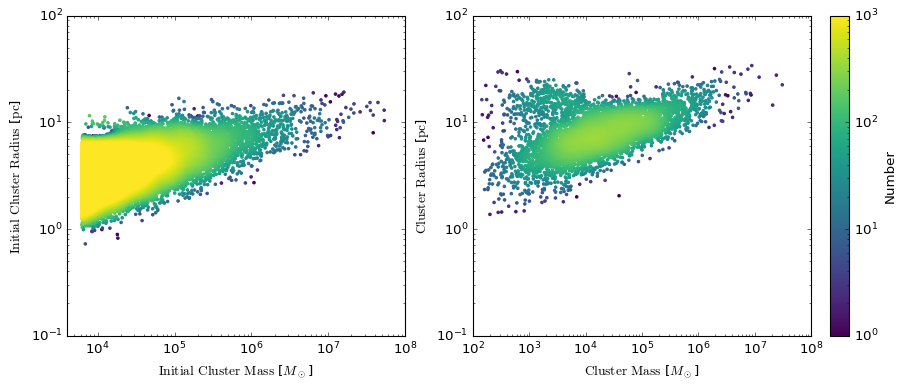

In [308]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0], cb = density_scatter(init_cluster_masses, init_cluster_radius, vmin=1e0, vmax=1e3, ax=ax[0],bins=[marray_icmf, rharray], edgecolors='face', s=5)
ax[0].set(xscale='log', yscale='log', xlim=(4e3, 1e8), ylim=(1e-1, 1e2), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Radius}$ [$\rm{pc}$]')
ax[1], cb = density_scatter(cluster_masses, cluster_radius, vmin=1e0, vmax=1e3, ax=ax[1],bins=[marray_gcmf, rharray], edgecolors='face', s=5)
ax[1].set(xscale='log', yscale='log', xlim=(1e2, 1e8), ylim=(1e-1, 1e2), xlabel=r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Cluster}$ $\rm{Radius}$ [$\rm{pc}$]')

cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.ax.set_ylabel('Number')

In [309]:
def rh_from_half_mass_density(rho, m):
    return (3*m/(8*np.pi*rho))**(1./3.)

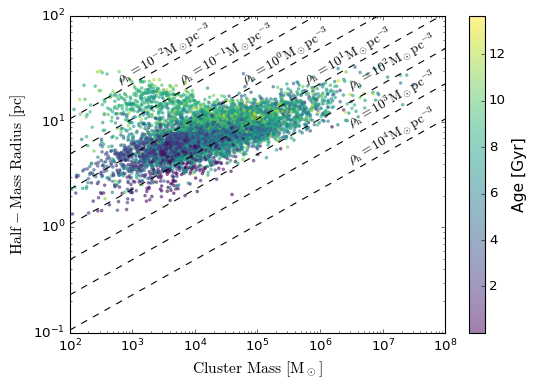

In [310]:
m_array = np.logspace(2, 8, 100)
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
cb = ax.scatter(cluster_masses, cluster_radius, c=clusters_age, cmap=cm.viridis, s=5, alpha=0.5, edgecolors='face')
ax.plot(m_array, rh_from_half_mass_density(0.01, m_array), 'k--')
ax.text(5e2, 2.3e1, r'$\rho_\mathrm{h} = 10^{-2} \mathrm{M}_\odot \mathrm{pc}^{-3}$', rotation=30)
ax.plot(m_array, rh_from_half_mass_density(0.1, m_array), 'k--')
ax.text(5e3, 2.3e1, r'$\rho_\mathrm{h} = 10^{-1} \mathrm{M}_\odot \mathrm{pc}^{-3}$', rotation=30)
ax.plot(m_array, rh_from_half_mass_density(1., m_array), 'k--')
ax.text(5e4, 2.3e1, r'$\rho_\mathrm{h} = 10^0 \mathrm{M}_\odot \mathrm{pc}^{-3}$', rotation=30)
ax.plot(m_array, rh_from_half_mass_density(10., m_array), 'k--')
ax.text(5e5, 2.3e1, r'$\rho_\mathrm{h} = 10^1 \mathrm{M}_\odot \mathrm{pc}^{-3}$', rotation=30)
ax.plot(m_array, rh_from_half_mass_density(100., m_array), 'k--')
ax.text(2.5e6, 2e1, r'$\rho_\mathrm{h} = 10^2 \mathrm{M}_\odot \mathrm{pc}^{-3}$', rotation=30)
ax.plot(m_array, rh_from_half_mass_density(1000., m_array), 'k--')
ax.text(2.5e6, 0.9e1, r'$\rho_\mathrm{h} = 10^3 \mathrm{M}_\odot \mathrm{pc}^{-3}$', rotation=30)
ax.plot(m_array, rh_from_half_mass_density(10000., m_array), 'k--')
ax.text(2.5e6, 4e0, r'$\rho_\mathrm{h} = 10^4 \mathrm{M}_\odot \mathrm{pc}^{-3}$', rotation=30)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e2, 1e8)
ax.set_ylim(1e-1, 1e2)
ax.set_xlabel(r'$\rm{Cluster}$ $\rm{Mass}$ $[\rm{M}_\odot]$', fontsize=14)
ax.set_ylabel(r'$\rm{Half-Mass}$ $\rm{Radius}$ $[\rm{pc}]$', fontsize=14)
cbar = fig.colorbar(cb)
cbar.set_label('Age [Gyr]', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('final_mass_radius.png')

In [315]:
TTij = s.data['ttij'][starparts][mask_cluster_initial] / s.parameters['UnitTime_in_s']**2
TTeig = np.linalg.eigvalsh(TTij.reshape(mask_cluster_initial.sum(), 3, 3))
TTeig = np.sort(TTeig, axis=1)

Tstr = np.repeat(TTeig[:,2] + np.sum(np.abs(TTeig), axis=1), s.data['incl'][starparts][mask_cluster_initial])
rT = (G_cgs * cluster_masses*solar_mass_g / Tstr)**(1/3) / parsec

/tmp/ipykernel_534833/2589283209.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(rT, cluster_radius, c=np.log10(cluster_masses), alpha=0.25)


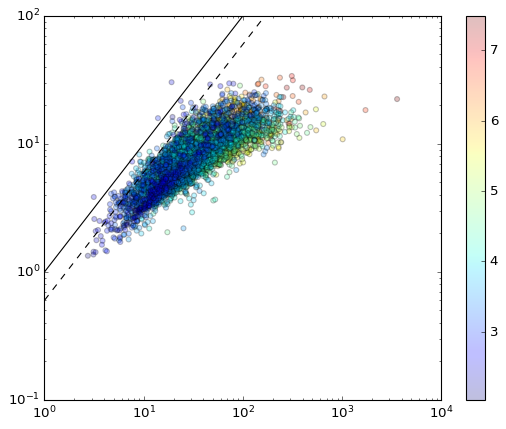

In [316]:
plt.scatter(rT, cluster_radius, c=np.log10(cluster_masses), alpha=0.25)
plt.plot(np.logspace(0, 4, 100), np.logspace(0, 4, 100), 'k')
plt.plot(np.logspace(0, 4, 100), 0.6*np.logspace(0, 4, 100), 'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0, 1e4)
plt.ylim(1e-1, 1e2)
plt.colorbar()

(array([ 1., 11.,  6., 17., 14., 13., 11.,  7.,  5.,  3.]),
 array([2.16016729, 2.40354947, 2.64693165, 2.89031384, 3.13369602,
        3.3770782 , 3.62046038, 3.86384257, 4.10722475, 4.35060693,
        4.59398911]),
 <BarContainer object of 10 artists>)

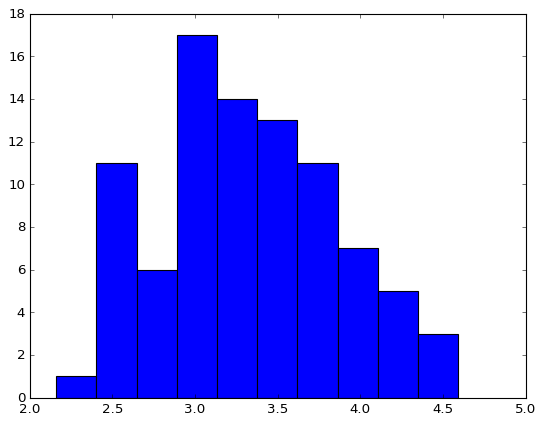

In [317]:
plt.hist(np.log10(cluster_masses[cluster_radius>0.6*rT]))

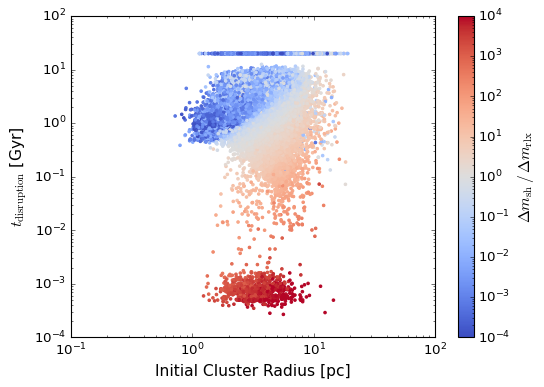

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
cb = ax.scatter(init_cluster_radius, lifetime_gyr, edgecolors='face', s=5, c=lossratio, cmap=cm.coolwarm, norm=mcolors.LogNorm(vmin=1e-4, vmax=1e4))
ax.set(xscale='log', yscale='log')#, xlim=(5e-2, 2e2), ylim=(1e-3, 2e1))
ax.set_xlabel('Initial Cluster Radius [pc]', fontsize=14)
ax.set_ylabel(r'$t_{\rm{disruption}}$ [Gyr]', fontsize=14)
cbar = fig.colorbar(cb)
cbar.set_label(r'$\Delta m_\mathrm{sh} \, / \, \Delta m_\mathrm{rlx}$', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('lifetime_radius.png')

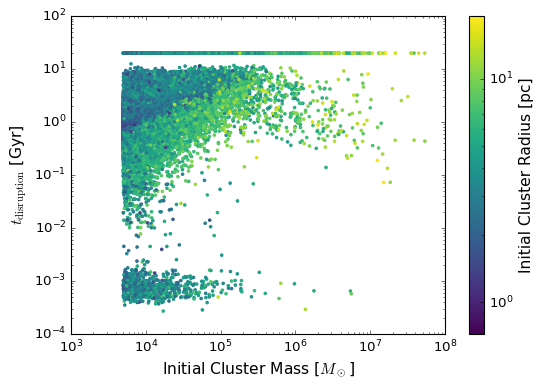

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
cb = ax.scatter(init_cluster_masses, lifetime_gyr, edgecolors='face', s=5, c=init_cluster_radius, cmap=cm.viridis, norm=mcolors.LogNorm())
ax.set(xscale='log', yscale='log')#, xlim=(4e3, 1e8), ylim=(1e-3, 2e1))
ax.set_xlabel(r'Initial Cluster Mass [$M_\odot$]', fontsize=14)
ax.set_ylabel(r'$t_{\rm{disruption}}$ [Gyr]', fontsize=14)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label('Initial Cluster Radius [pc]', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('initial_mass_lifetime.png')

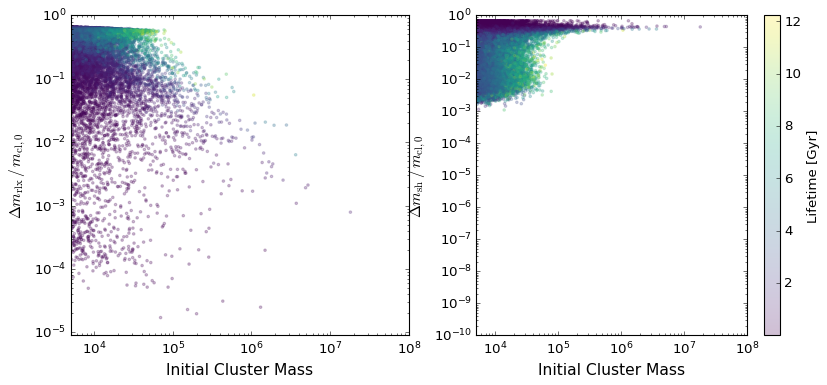

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

h = ax[0].scatter(init_cluster_masses[lifetime_gyr<16], masslostrelax[lifetime_gyr<16]/init_cluster_masses[lifetime_gyr<16], s=5, c=lifetime_gyr[lifetime_gyr<16], cmap=cm.viridis, edgecolors='face', alpha=0.25)
ax[0].set_xlabel('Initial Cluster Mass', fontsize=14)
ax[0].set_ylabel(r'$\Delta m_\mathrm{rlx} \, / \, m_{\rm{cl,0}}$', fontsize=14)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(5e3, 1e8)
ax[0].set_ylim(9e-6, 1)

h = ax[1].scatter(init_cluster_masses[lifetime_gyr<16], masslostshock[lifetime_gyr<16]/init_cluster_masses[lifetime_gyr<16], s=5, c=lifetime_gyr[lifetime_gyr<16], cmap=cm.viridis, edgecolors='face', alpha=0.25)
ax[1].set_xlabel('Initial Cluster Mass', fontsize=14)
ax[1].set_ylabel(r'$\Delta m_\mathrm{sh} \, / \, m_{\rm{cl,0}}$', fontsize=14)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(5e3, 1e8)
ax[1].set_ylim(1e-10, 1)

fig.colorbar(h, label='Lifetime [Gyr]')

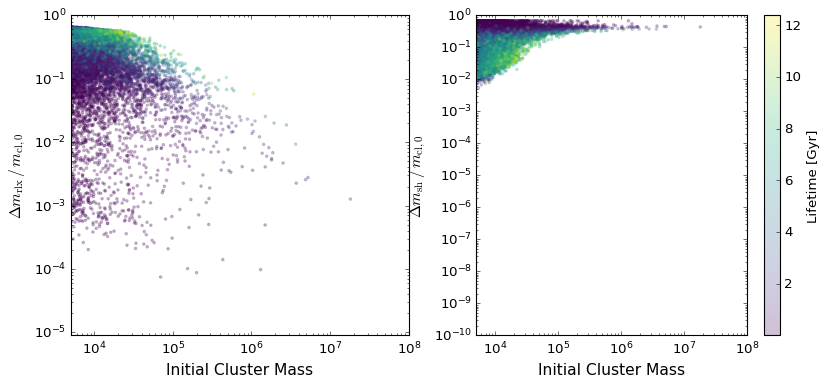

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

h = ax[0].scatter(init_cluster_masses[lifetime_gyr<16], masslostrelax[lifetime_gyr<16]/init_cluster_masses[lifetime_gyr<16], s=5, c=lifetime_gyr[lifetime_gyr<16], cmap=cm.viridis, edgecolors='face', alpha=0.25)
ax[0].set_xlabel('Initial Cluster Mass', fontsize=14)
ax[0].set_ylabel(r'$\Delta m_\mathrm{rlx} \, / \, m_{\rm{cl,0}}$', fontsize=14)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(5e3, 1e8)
ax[0].set_ylim(9e-6, 1)

h = ax[1].scatter(init_cluster_masses[lifetime_gyr<16], masslostshock[lifetime_gyr<16]/init_cluster_masses[lifetime_gyr<16], s=5, c=lifetime_gyr[lifetime_gyr<16], cmap=cm.viridis, edgecolors='face', alpha=0.25)
ax[1].set_xlabel('Initial Cluster Mass', fontsize=14)
ax[1].set_ylabel(r'$\Delta m_\mathrm{sh} \, / \, m_{\rm{cl,0}}$', fontsize=14)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(5e3, 1e8)
ax[1].set_ylim(1e-10, 1)

fig.colorbar(h, label='Lifetime [Gyr]')

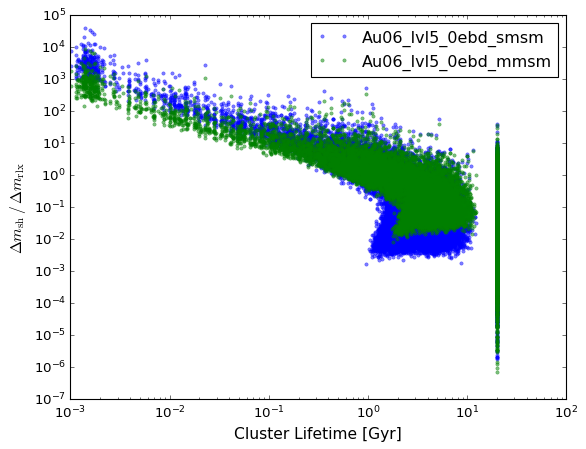

In [36]:
plt.loglog(compare_lifetime[0], compare_lossratio[0], '.', label=simulation_list[0], alpha=0.5)
plt.loglog(compare_lifetime[1], compare_lossratio[1], '.', label=simulation_list[1], alpha=0.5)
plt.xlabel('Cluster Lifetime [Gyr]', fontsize=14)
plt.ylabel(r'$\Delta m_\mathrm{sh} \, / \, \Delta m_\mathrm{rlx}$', fontsize=14)
plt.legend()

In [37]:
(compare_lifetime[0]<16).sum(),(compare_lifetime[1]<16).sum()

(np.int64(27918), np.int64(16700))

Text(0, 0.5, 'Au06_lvl5_0ebd_mmsm $\\Delta m_\\mathrm{rlx}/m_\\mathrm{init}$')

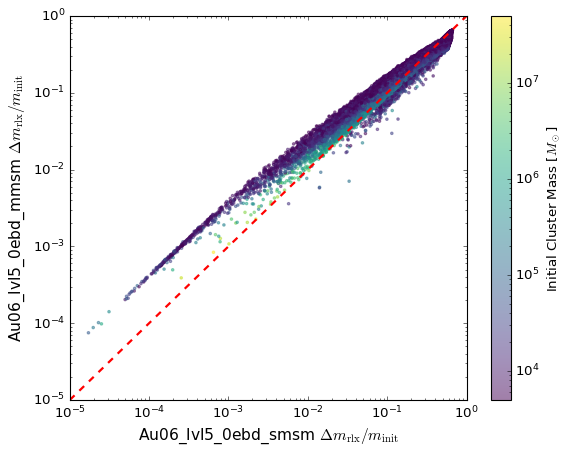

In [73]:
plt.scatter(compare_mlrelax[0]/compare_initialmass[0], compare_mlrelax[1]/compare_initialmass[1], c=compare_initialmass[0],
            norm=mcolors.LogNorm(), cmap=cm.viridis, edgecolors='face', s=5, alpha=0.5)
plt.plot([1e-5, 1e0], [1e-5, 1e0], 'r--', linewidth=2)
plt.colorbar(label='Initial Cluster Mass [$M_\odot$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-5, 1)
plt.ylim(1e-5, 1)
plt.xlabel(simulation_list[0] + r' $\Delta m_\mathrm{rlx}/m_\mathrm{init}$', fontsize=14)
plt.ylabel(simulation_list[1] + r' $\Delta m_\mathrm{rlx}/m_\mathrm{init}$', fontsize=14)

Text(0, 0.5, 'Au06_lvl5_0ebd_mmsm, $\\Delta m_\\mathrm{sh}/m_\\mathrm{init}$')

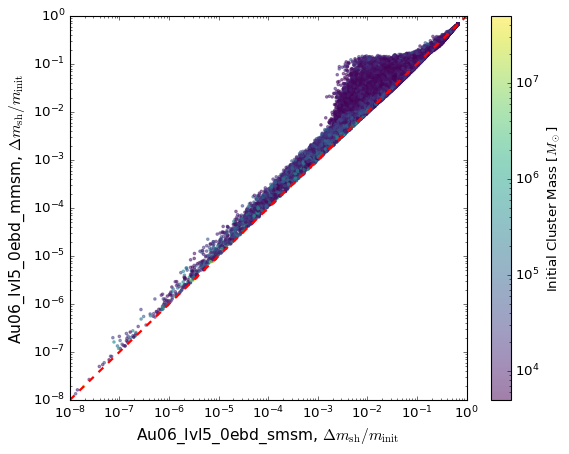

In [95]:
plt.scatter(compare_mlshock[0]/compare_initialmass[0], compare_mlshock[1]/compare_initialmass[1], c=compare_initialmass[0],
            norm=mcolors.LogNorm(), cmap=cm.viridis, edgecolors='face', s=5, alpha=0.5)
plt.plot([1e-8, 1e0], [1e-8, 1e0], 'r--', linewidth=2)
plt.colorbar(label='Initial Cluster Mass [$M_\odot$]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-8, 1)
plt.ylim(1e-8, 1)
plt.xlabel(simulation_list[0] + r', $\Delta m_\mathrm{sh}/m_\mathrm{init}$', fontsize=14)
plt.ylabel(simulation_list[1] + r', $\Delta m_\mathrm{sh}/m_\mathrm{init}$', fontsize=14)

Text(0, 0.5, 'Au06_lvl5_0ebd_mmsm, $r_\\mathrm{h}/r_\\mathrm{h,init}$')

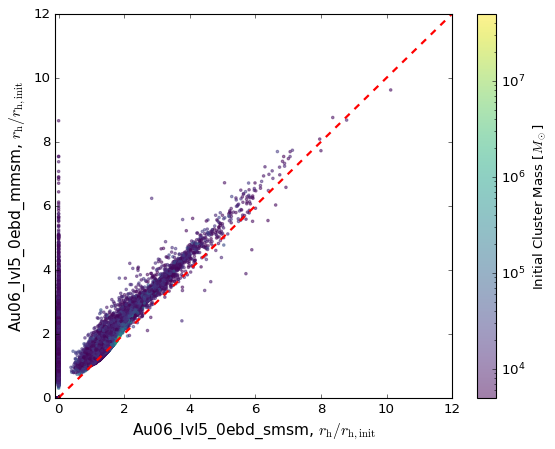

In [102]:
plt.scatter(compare_finalrh[0]/compare_initialrh[0], compare_finalrh[1]/compare_initialrh[1], c=compare_initialmass[0],
            norm=mcolors.LogNorm(), cmap=cm.viridis, edgecolors='face', s=5, alpha=0.5)
plt.colorbar(label='Initial Cluster Mass [$M_\odot$]')
plt.plot([0,12], [0,12], 'r--', linewidth=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(-.1, 12)
plt.ylim(0, 12)
plt.xlabel(simulation_list[0] + r', $r_\mathrm{h}/r_\mathrm{h,init}$', fontsize=14)
plt.ylabel(simulation_list[1] + r', $r_\mathrm{h}/r_\mathrm{h,init}$', fontsize=14)

In [68]:
(compare_initialmass[0] == compare_initialmass[1]).all()

np.True_